In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lab2_proto import *
from lab2_tools import *

from prondict import *

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [3]:
phoneHMMs_one = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [4]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

In [5]:
wordHMMs_one = {}
wordHMMs_all = {}

for digit in prondict.keys():
    wordHMMs_one[digit] = concatHMMs(phoneHMMs_one, isolated[digit])
    wordHMMs_all[digit] = concatHMMs(phoneHMMs_all, isolated[digit])


In [6]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

## 5.1 Gaussian emission probabilities

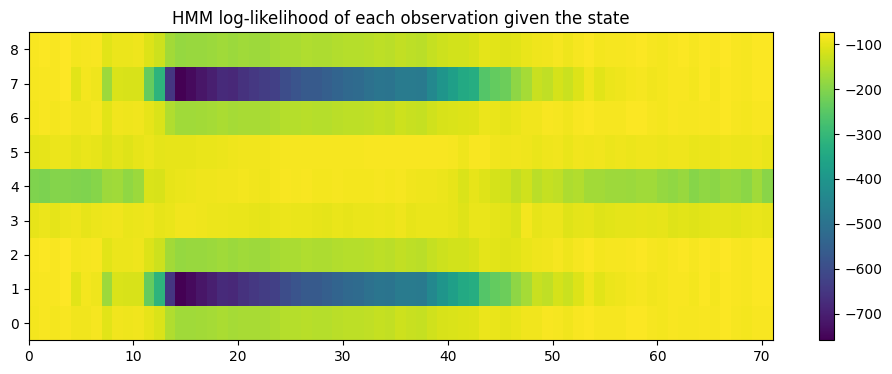

In [7]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs_one['o']['means'], wordHMMs_one['o']['covars'])

plt.figure(figsize=(12, 4))
plt.pcolormesh(obsloglik.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state")
plt.yticks(np.arange(9) + 0.5, np.arange(9))

assert np.allclose(obsloglik, example['obsloglik'])

Plot the log likelihood for Gaussians from HMMs models corresponding to the same digit on
a test utterance of your choice. What can you say about the figure? Which Gaussian components
give the high likelihood in which time steps? Why? Remember that each utterance starts and
ends with silence.

Text(0.5, 1.0, 'HMM log-likelihood of each observation given the state (all speakers)')

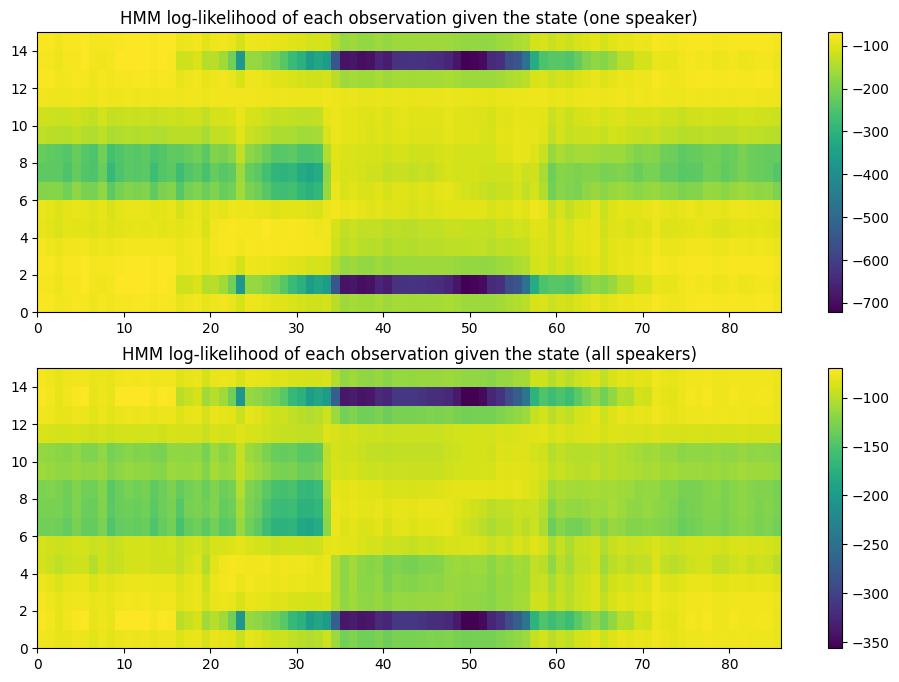

In [8]:
test_utterance = data[10]

HMM_one = wordHMMs_one[test_utterance['digit']]
HMM_all = wordHMMs_all[test_utterance['digit']]

obsloglik_one = log_multivariate_normal_density_diag(test_utterance['lmfcc'], HMM_one['means'], HMM_one['covars'])
obsloglik_all = log_multivariate_normal_density_diag(test_utterance['lmfcc'], HMM_all['means'], HMM_all['covars'])

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.pcolormesh(obsloglik_one.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state (one speaker)")

plt.subplot(2, 1, 2)
plt.pcolormesh(obsloglik_all.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state (all speakers)")

## 5.2 Forward algorithm

C:\Users\elioc\AppData\Local\Temp\ipykernel_22392\3920808951.py:1: RuntimeWarning: divide by zero encountered in log
  log_alpha = forward(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]))


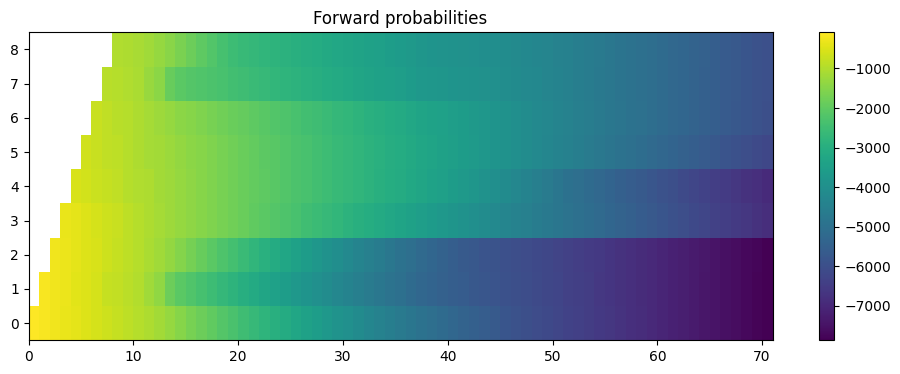

In [19]:
log_alpha = forward(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]))

plt.figure(figsize=(12, 4))
plt.pcolormesh(log_alpha.T)
plt.colorbar()
plt.yticks(np.arange(9) + 0.5, np.arange(9))
plt.title("Forward probabilities")

assert np.allclose(log_alpha, example['logalpha'])

In [21]:
def sequence_likelihood_forward(log_alpha):
    """
    Compute the sequence likelihood given the forward probabilities (log_alpha),
    """
    return logsumexp(log_alpha[-1, :])


loglik_forward = sequence_likelihood_forward(log_alpha)
example['loglik'], loglik_forward

(np.float64(-5970.427602563561), np.float64(-5970.427602563561))

Using your formula, score all the 44 utterances in the data array with each of the 11 HMM
models in wordHMMs. Do you see any mistakes if you take the maximum likelihood model as
winner? Compare the results obtained from the models trained on a single speaker or all the
training speakers.

In [22]:
from tqdm import tqdm


def score_utterrances(data, wordHMMs):
    """
    Compute the log-likelihood of each utterance in data given the wordHMMs.
    """
    scores = []
    for i in tqdm(range(len(data))):
        for h in wordHMMs.keys():
            obsloglik = log_multivariate_normal_density_diag(data[i]['lmfcc'], wordHMMs[h]['means'], wordHMMs[h]['covars'])
            log_alpha = forward(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]))
            scores.append(sequence_likelihood_forward(log_alpha))
    return np.array(scores).reshape(len(data), len(wordHMMs))

lik_all = score_utterrances(data, wordHMMs_all)
lik_one = score_utterrances(data, wordHMMs_one)

  0%|          | 0/44 [00:00<?, ?it/s]

C:\Users\elioc\AppData\Local\Temp\ipykernel_22392\3616961128.py:12: RuntimeWarning: divide by zero encountered in log
  log_alpha = forward(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]))
100%|██████████| 44/44 [00:10<00:00,  4.28it/s]


In [23]:
def max_lik_pred(lik, wordHMMs):
    """
    Predict the digit for each utterance in data using the maximum likelihood criterion.
    """
    pred = np.argmax(lik, axis=1)
    return [list(wordHMMs.keys())[i] for i in pred]

def accuracy(pred, data):
    """
    Compute the accuracy of the predictions.
    """
    correct = 0
    for i in range(len(data)):
        if pred[i] == data[i]['digit']:
            correct += 1
    return correct / len(data)

pred_all = max_lik_pred(lik_all, wordHMMs_all)
pred_one = max_lik_pred(lik_one, wordHMMs_one)

acc_all = accuracy(pred_all, data)
acc_one = accuracy(pred_one, data)

print(f"Accuracy (all speakers): {acc_all:.2f}")
print(f"Accuracy (one speaker): {acc_one:.2f}")

Accuracy (all speakers): 0.98
Accuracy (one speaker): 0.77


## 5.3 Viterbi Approximation

In [24]:
log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]), forceFinalState=True)
assert np.allclose(log_V, example['vloglik'])

C:\Users\elioc\AppData\Local\Temp\ipykernel_22392\4013680231.py:1: RuntimeWarning: divide by zero encountered in log
  log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs_one['o']['startprob'])[:-1], np.log(wordHMMs_one['o']['transmat'][:-1, :-1]), forceFinalState=True)


In [25]:
def score_utterrances_viterbi(data, wordHMMs):
    """
    Compute the log-likelihood of each utterance in data given the wordHMMs using Viterbi.
    """
    scores = []
    for i in tqdm(range(len(data))):
        for h in wordHMMs.keys():
            obsloglik = log_multivariate_normal_density_diag(data[i]['lmfcc'], wordHMMs[h]['means'], wordHMMs[h]['covars'])
            log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]), forceFinalState=True)
            scores.append(log_V)
    return np.array(scores).reshape(len(data), len(wordHMMs))

lik_all_viterbi = score_utterrances_viterbi(data, wordHMMs_all)
lik_one_viterbi = score_utterrances_viterbi(data, wordHMMs_one)

  0%|          | 0/44 [00:00<?, ?it/s]C:\Users\elioc\AppData\Local\Temp\ipykernel_22392\4025665117.py:9: RuntimeWarning: divide by zero encountered in log
  log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs[h]['startprob'])[:-1], np.log(wordHMMs[h]['transmat'][:-1, :-1]), forceFinalState=True)
100%|██████████| 44/44 [00:03<00:00, 12.66it/s]


In [26]:
pred_all_viterbi = max_lik_pred(lik_all_viterbi, wordHMMs_all)
pred_one_viterbi = max_lik_pred(lik_one_viterbi, wordHMMs_one)

acc_all_viterbi = accuracy(pred_all_viterbi, data)
acc_one_viterbi = accuracy(pred_one_viterbi, data)

print(f"Accuracy (all speakers, Viterbi): {acc_all_viterbi:.2f}")
print(f"Accuracy (one speaker, Viterbi): {acc_one_viterbi:.2f}")

Accuracy (all speakers, Viterbi): 1.00
Accuracy (one speaker, Viterbi): 0.77


## 5.4 Backward algorithm

C:\Users\elioc\AppData\Local\Temp\ipykernel_22392\240599911.py:4: RuntimeWarning: divide by zero encountered in log
  np.log(wordHMMs_one['o']['startprob'])[:-1],
C:\Users\elioc\AppData\Local\Temp\ipykernel_22392\240599911.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(wordHMMs_one['o']['transmat'][:-1, :-1])


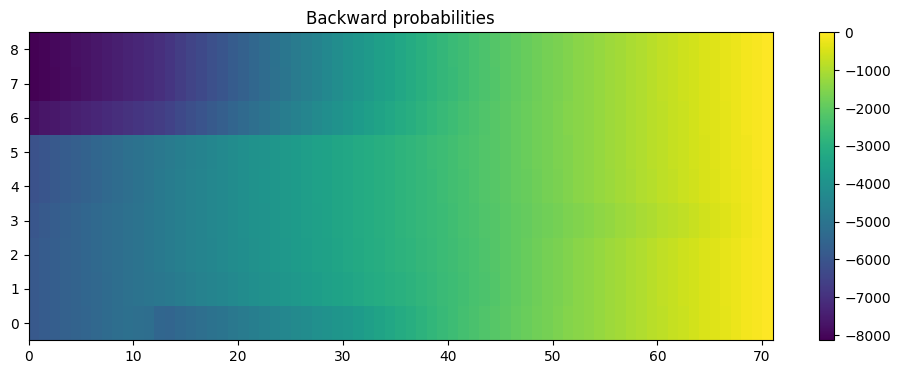

In [27]:
log_beta = backward(
    log_multivariate_normal_density_diag(
        example['lmfcc'], wordHMMs_one['o']['means'], wordHMMs_one['o']['covars']),
    np.log(wordHMMs_one['o']['startprob'])[:-1],
    np.log(wordHMMs_one['o']['transmat'][:-1, :-1])
)
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_beta.T)
plt.yticks(np.arange(9) + 0.5, np.arange(9))
plt.colorbar()
plt.title("Backward probabilities")

assert np.allclose(log_beta, example['logbeta'])

In [46]:
def sequence_likelihood_backward(log_beta, log_start_probs):
    """
    Compute the sequence likelihood given the backward probabilities (log_beta).
    """
    return logsumexp(log_beta[0] + log_start_probs)

loglik_forward = sequence_likelihood_forward(log_alpha)
loglik_backward = sequence_likelihood_backward(log_beta, np.log(wordHMMs_one['o']['startprob'][:-1]))

example['loglik'], loglik_backward, loglik_forward

C:\Users\elioc\AppData\Local\Temp\ipykernel_22392\3228901480.py:8: RuntimeWarning: divide by zero encountered in log
  loglik_backward = sequence_likelihood_backward(log_beta, np.log(wordHMMs_one['o']['startprob'][:-1]))


(np.float64(-5970.427602563561),
 np.float64(-5884.066355177514),
 np.float64(-5970.427602563561))

## 6.1 State posterior probabilities

In [47]:
log_gamma = statePosteriors(log_alpha, log_beta)

# Check that the sum of the gamma is 1 for each time frame
assert np.allclose(np.sum(np.exp(log_gamma), axis=1), 1)

Text(0.5, 1.0, 'State posterior probabilities')

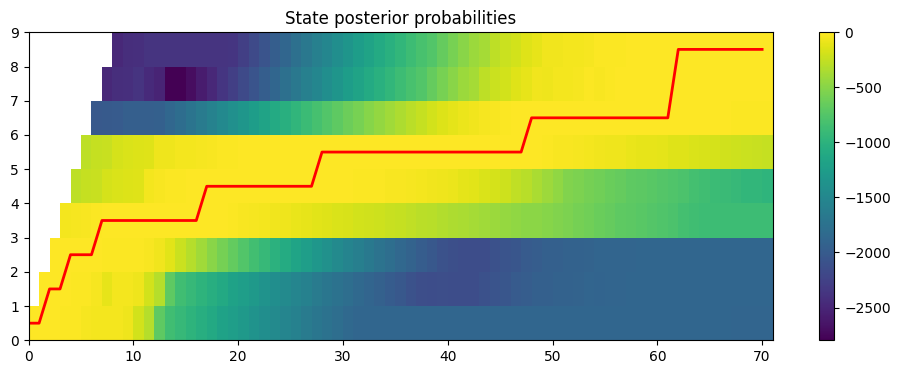

In [48]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_gamma.T)
plt.colorbar()
plt.plot(viterbi_path+0.5, 'r', lw=2)
plt.title("State posterior probabilities")